In [0]:
!wget https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d -O files.zip
!unzip files.zip
!pip install transformers

In [1]:
from daniel_lib import (tokenizer, import_file, pad, 
                        bert_model, get_tokenized, getDataLoader, 
                        removeOutliers, progress, get_sentence_embeddings, 
                        augment_dataset, BERThoven, check_accuracy, train_part, get_test_labels)
from transformers import (AdamW,
                          get_linear_schedule_with_warmup)
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import scipy

In [0]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [0]:
train_df = import_file("train")
dev_df = import_file("dev")
test_df = import_file("test")

dataLoader_train = getDataLoader(train_df)
dataLoader_dev = getDataLoader(dev_df)
dataLoader_test = getDataLoader(test_df,test=True)

In [0]:
train_df_aug = augment_dataset(train_df, 
                            lambda score: score<-1,
                            lambda score: score<-0.3, 
                            lambda score: score>0.55, 
                            lambda score: score>1, 
                            lambda score: score>1.3)
dataLoader_train_aug = getDataLoader(train_df_aug)

In [0]:
# print(train_df2.shape)
# plt.subplot(2,1,1)
# train_df.scores.hist(bins=100)
# plt.subplot(2,1,2)
# train_df2.scores.hist(bins=100)
# print(train_df.scores.mean(), train_df2.scores.mean())
# print(train_df.scores.var(), train_df2.scores.var())

# train_df[train_df.src == train_df.mt]
# train_df[train_df.scores>0.5]
# train_df.scores.hist(bins=100)

In [0]:
nlp_model = BERThoven(bert_model)
# nlp_model.load_state_dict(torch.load("nlp_model.pt"))
check_accuracy(dataLoader_dev,nlp_model,device=device)

In [0]:
epochs = 10
warmup_proportion = 0.1

loss_function = F.l1_loss
print_every=75

steps_per_epoch = len(dataLoader_train_aug)
training_steps = steps_per_epoch*epochs
warmup_steps = int(training_steps*warmup_proportion)


optimizer = AdamW(nlp_model.parameters(), lr=1e-6,eps=1e-9, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=training_steps)

train_part(nlp_model, dataLoader_train_aug, optimizer,scheduler, 
           val_loader=dataLoader_dev, 
           epochs=epochs-2, 
           print_every=print_every, 
           loss_function=loss_function, 
           device=device)
train_part(nlp_model, dataLoader_train_aug, optimizer, scheduler, 
           val_loader=dataLoader_dev, 
           epochs=2, 
           print_every=print_every, 
           loss_function=loss_function, 
           device=device)

Iterations per epoch:308

Epoch: 0, Iteration 0, loss = 0.8352, avg_loss = 0.9918...........................................................................

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52b5a05b70>]],
      dtype=object)

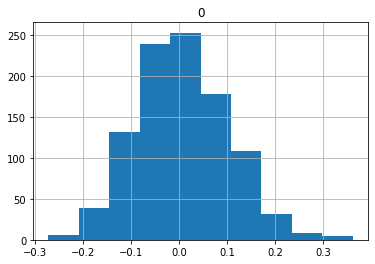

In [15]:
# check_accuracy(dataLoader_dev,nlp_model)

# def writeScores(scores):
#     fn = "predictions.txt"
#     print("")
#     with open(fn, 'w') as output_file:
#         for x in scores:
#             output_file.write(f"{x}\n")
# p.hist()
# dev_df.hist()
labels=get_test_labels(dataLoader_test, nlp_model)
p=pd.DataFrame(labels)#.hist()
# p.head()
p.hist()

### Try using only embeddings

In [0]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.lin_layer1 = nn.Linear(768*2, 1000)
        self.relu1 = nn.LeakyReLU()
        self.lin_layer2 = nn.Linear(1000, 1000)
        self.relu2 = nn.LeakyReLU()
        self.lin_layer3 = nn.Linear(1000, 1)


    def forward(self, x1, x2):
        inp = torch.cat((x1,x2),1)
        out1 = self.relu1(self.lin_layer1(inp))
        out2 = self.relu2(self.lin_layer2(out1))
        out3 = self.lin_layer3(out2)
        return out3.squeeze()

In [0]:
print_every=500
def train_linear_model(model, dataloader, dataloader_val, optimizer, scheduler, epochs=1,max_grad_norm=1.0):

    avg_loss = 1;
    momentum = 0.01;

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(f"Iterations per epoch:{len(dataloader)}")
        for t, ((x1,x2),y) in enumerate(dataloader):
            model.train()  # put model to training mode
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x1,x2)
            
            loss = F.mse_loss(scores, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            scheduler.step()
            l=loss.item()

            avg_loss = l*momentum + avg_loss*(1-momentum)

            if t % print_every == 0:
                print()
                print('Epoch: %d, Iteration %d, loss = %.4f, avg_loss = %.4f' % (e, t, l,avg_loss), end="")
            print(".",end="")
        print()
        print("Avg loss %.3f" % (avg_loss))
        print("Checking accuracy on dev:")
        check_accuracy_linear(dataloader_val, model)
        # print("Saving the model.")
        # torch.save(model.state_dict(), 'nlp_model.pt')

def check_accuracy_linear(loader, model, max_sample_size=None):
    model = model.to(device=device)
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    abs_error = 0
    sqr_error = 0;
    
    with torch.no_grad():
        for (x1, x2), y in loader:
            y = y.to(device=device, dtype=torch.float32)
            scores = model.forward(x1,x2)
            abs_error += (scores - y).abs().sum()
            sqr_error += ((scores - y)**2).sum()
            num_samples += scores.size(0)
            if(max_sample_size!=None and num_samples>=num_samples):
              break;
        mse = sqr_error/num_samples
        mae = abs_error/num_samples
        print('Mean Absolute Error: %.3f, Mean Squared Error %.3f' % (mse, mae))

In [0]:
train_embeddings = get_sentence_embeddings(train_df,bert_model)
val_embeddings = get_sentence_embeddings(dev_df,bert_model)

In [0]:
epochs = 10
warmup_proportion = 0.1

steps_per_epoch = len(train_embeddings)
training_steps = steps_per_epoch*epochs
warmup_steps = int(training_steps*warmup_proportion)

linear_model=LinearModel()

optimizer = AdamW(linear_model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=training_steps)

train_linear_model(linear_model, train_embeddings,val_embeddings,optimizer,scheduler, epochs=epochs)